# LSC Project 2021 Land Sat Temp Machine Learning (oabreu_sjaisha_gdmorrison)

In [129]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
import datetime
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Let's start by reading our Landsat Images Dataframe composed of all the features we extracted/engineered using parallelization from the band data into the environment.

In [168]:
df = pd.read_csv('df2.csv')
#df.drop(columns = ["Unnamed: 0"])
display(df.head())
display(df.dtypes)
display(df.describe())

,Unnamed: 0,ndvi,ndsi,ndbi,albedo,awei,gemi,LST,ndvi_lag,ndsi_lag,ndbi_lag,albedo_lag,awei_lag,gemi_lag,LST_lag,community,period,year
0,0,0.019076,0.153550,-0.163155,0.607362,1.882809,-0.903871,276.523380,0.049917,0.086155,-0.131378,0.501135,1.419662,-0.427217,279.788652,1.0,1.0,2013.0
1,1,0.083315,0.039830,-0.124366,0.368263,0.914185,0.221260,283.478349,0.139216,0.021040,-0.156492,0.473041,1.328839,-0.409352,282.169624,2.0,1.0,2013.0
2,2,0.010179,0.169821,-0.172797,0.617248,1.910952,-0.952037,276.519069,0.031010,0.125091,-0.150192,0.543724,1.598575,-0.479277,278.620741,3.0,1.0,2013.0
3,3,0.037017,0.114391,-0.152306,0.510350,1.426391,-0.223004,279.451761,0.130239,0.011503,-0.139664,0.409243,1.097867,-0.122363,284.583449,4.0,1.0,2013.0
4,4,0.037763,0.119415,-0.157467,0.485321,1.382989,-0.160794,281.408990,0.114833,0.002798,-0.119861,0.387643,1.017787,-0.038475,286.040619,5.0,1.0,2013.0


Unnamed: 0      int64
ndvi          float64
ndsi          float64
ndbi          float64
albedo        float64
awei          float64
gemi          float64
LST           float64
ndvi_lag      float64
ndsi_lag      float64
ndbi_lag      float64
albedo_lag    float64
awei_lag      float64
gemi_lag      float64
LST_lag       float64
community     float64
period        float64
year          float64
dtype: object

,Unnamed: 0,ndvi,ndsi,ndbi,albedo,awei,gemi,LST,ndvi_lag,ndsi_lag,ndbi_lag,albedo_lag,awei_lag,gemi_lag,LST_lag,community,period,year
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,615.500000,0.138682,-0.064149,-0.129187,0.333211,0.823344,-0.048708,280.961080,0.161439,-0.063259,-0.129450,0.335639,0.829636,-0.050119,281.167063,39.000000,1.500000,2016.500000
std,355.792074,1.178959,0.222542,0.137809,0.205186,0.784641,0.920449,31.625385,0.430596,0.207122,0.094852,0.189502,0.732919,0.807232,29.954097,22.235137,0.500203,2.292218
min,0.000000,-28.819356,-1.082993,-2.096368,-0.101832,-0.346372,-6.324060,131.303018,-7.037332,-0.383926,-0.638440,0.096104,0.026513,-4.005951,205.984376,1.000000,1.000000,2013.000000
25%,307.750000,0.030334,-0.248605,-0.146723,0.150188,0.160786,-0.260273,269.780707,0.049869,-0.243943,-0.136536,0.150030,0.170908,-0.309993,269.668017,20.000000,1.000000,2014.750000
50%,615.500000,0.168994,-0.106112,-0.106572,0.250547,0.465112,0.411201,294.762619,0.165653,-0.091342,-0.108709,0.275910,0.572761,0.357113,292.429913,39.000000,1.500000,2016.500000
75%,923.250000,0.318900,0.096069,-0.074838,0.514831,1.494611,0.489959,303.859361,0.297884,0.068416,-0.079068,0.488135,1.417710,0.482864,303.415602,58.000000,2.000000,2018.250000
max,1231.000000,1.062513,0.564388,1.313699,0.805480,2.988590,0.618389,321.272348,0.550040,0.523617,0.169436,0.748183,2.806167,0.573395,313.722899,77.000000,2.000000,2020.000000


In [224]:
default_split = {0: [[2015], 2016],
                 1: [[2015, 2016], 2017],
                 2: [[2015, 2016, 2017], 2018],
                 3: [[2015, 2016, 2017, 2018], 2019],
                 4: [[2015, 2016, 2017, 2018, 2019], 2020]}
                 
test_year = 2020
default_ycol = "LST"
default_selection_param = "RMSE"

In [230]:
#All custom functions for ML modeling
def pipe_normalize(df, scaler=None, outputinc=False, outputcol=None):
    '''
    Normalizes dataframe (adapted from Nick Feamster's normalize function)
    Inputs:
        df (Pandas Dataframe)
        scaler (Scaler) :If scaler is not none, use given scaler's means and sds
                         to normalize (input for test set case); else, set 
                         scaler in function
        outputinc (bool): If output is included, set aside to ensure it does not
                          get normalized, default False
        outputcol (str): If output is included, name of output column, default
                         None
    Returns tuple of:
        Normalized DataFrame and scaler used to normalize DataFrame
    '''
    columns = df.columns
    if outputinc:
        outcomes = df.loc[:,outputcol]
        df = pd.DataFrame(df.drop(outputcol, axis=1))
    if scaler is None:
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(df) 
    else:
        normalized_features = scaler.transform(df)

    normalized_df = pd.DataFrame(normalized_features)
    if outputinc:
        normalized_df[outputcol] = outcomes.tolist()

    normalized_df.index=df.index
    normalized_df.columns= columns

    return normalized_df, scaler

def train_val_test_split(df, split = default_split, ycol = default_ycol):
    k = len(split)

    df_train = [pd.DataFrame(columns = list(df.columns))]*k
    df_val = [pd.DataFrame(columns = list(df.columns))]*k
    df_test = df[df["year"] == test_year]

    for i in range(k):
        for train_yr in split[i][0]:
            df_train[i] = df_train[i].append(df[df["year"] == train_yr])
        df_val[i] = df_val[i].append(df[df["year"] == split[i][1]])

    df_train_y = [None]*k
    df_train_x = [None]*k
    df_val_y = [None]*k
    df_val_x = [None]*k

    for i in range(k):
        df_train_y[i] = df_train[i][ycol]
        df_train_x[i] = df_train[i].drop(columns = [ycol, "year"])
        df_val_y[i] = df_val[i][ycol]
        df_val_x[i] = df_val[i].drop(columns = [ycol, "year"])
        df_test_y = df_test[ycol]
        df_test_x = df_test.drop(columns = [ycol, "year"])

    return df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x

def normalize(df_train_x, df_val_x, df_test_x):
    k = len(df_train_x)
    train_norm = []
    valid_norm = []
    for n in range(k):
        df = pd.concat((df_train_x[n], df_val_x[n]))
        df_norm, scaler = pipe_normalize(df)
        tr_norm = df_norm.loc[df_train_x[n].index,:]
        val_norm = df_norm.loc[df_val_x[n].index,:]
        train_norm.append(tr_norm)
        valid_norm.append(val_norm)
    te_norm, _ = pipe_normalize(df_test_x, scaler=scaler)
    test_norm = te_norm
    return train_norm, valid_norm, test_norm

def grid_search_time_series_cv(df_train_y, df_train_x, df_val_y, df_val_x,
                               models, p_grid, ret_int_results = False, print = False):
    k = len(df_train_y)
    val_results = [pd.DataFrame(columns = ["Model", "Params", "RMSE", "MAE", "R^2"])]*k

    for i in range(k):
        for model_key in models.keys():
            for params in p_grid[model_key]:
                if print == True:
                    print("Training model:", model_key, "|", params)
                model = models[model_key]
                model.set_params(**params)
                fitted_model = model.fit(df_train_x[i], df_train_y[i])
                test_predictions = fitted_model.predict(df_val_x[i])
                rmse = mean_squared_error(df_val_y[i], test_predictions, squared = False)
                mae = mean_absolute_error(df_val_y[i], test_predictions)
                r2 = r2_score(df_val_y[i], test_predictions)
                val_results[i] = val_results[i].append(pd.DataFrame([[model_key, params, rmse, mae, r2]],
                                                       columns = ["Model", "Params", "RMSE", "MAE", "R^2"]))

    avg_val_results = pd.DataFrame(columns = ["Model", "Params", "RMSE", "RMSE std dev", "MAE", "R^2"])
    avg_val_results["Model"] = val_results[0]["Model"]
    avg_val_results["Params"] = val_results[0]["Params"]
    avg_val_results["RMSE"] = [0]*len(val_results[0])
    avg_val_results["RMSE std dev"] = [0]*len(val_results[0])
    avg_val_results["MAE"] = [0]*len(val_results[0])
    avg_val_results["R^2"] = [0]*len(val_results[0])
    for i in range(k):
        avg_val_results["RMSE"] += val_results[i]["RMSE"]/k
        avg_val_results["MAE"] += val_results[i]["MAE"]/k
        avg_val_results["R^2"] += val_results[i]["R^2"]/k
    avg_val_results = avg_val_results.reset_index().drop(columns = ["index"])
    l0 = list(val_results[0]["RMSE"])
    l1 = list(val_results[1]["RMSE"])
    l2 = list(val_results[0]["RMSE"])
    for i in range(len(avg_val_results)):
        avg_val_results.iloc[i, [3]] = np.std([l0[i], l1[i], l2[i]])

    if ret_int_results == True:
        return avg_val_results, val_results
    else:
        return avg_val_results

def select_best_model(avg_val_results, selection_param = default_selection_param):
    best_model = avg_val_results[avg_val_results[selection_param] == avg_val_results[selection_param].min()].iloc[0]
    return best_model

def select_model(avg_val_results, row):
    chosen_model = avg_val_results.iloc[row]
    return chosen_model

def test_model(df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x,
               chosen_model, models):
    k = len(df_train_y)
    model = models[chosen_model["Model"]]
    model.set_params(**chosen_model["Params"])


    df_tv_x = pd.concat([df_train_x[k-1], df_val_x[k-1]])
    df_tv_y = pd.concat([df_train_y[k-1], df_val_y[k-1]])

    fitted_model = model.fit(df_tv_x, df_tv_y)
    test_predictions = fitted_model.predict(df_test_x)
    rmse = mean_squared_error(df_test_y, test_predictions, squared = False)
    mae = mean_absolute_error(df_test_y, test_predictions)
    r2 = r2_score(df_test_y, test_predictions)
    test_results = {"RMSE" : rmse, "MAE" : mae, "r^2" :r2}
    return test_results, df_test_x, df_test_y, test_predictions

def choose_and_test_model(df, models, p_grid, default_split, ycol = default_ycol, selection_param = default_selection_param):
    df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x = train_val_test_split(df, default_split, ycol)
    df_train_x, df_val_x, df_test_x = normalize(df_train_x, df_val_x, df_test_x)
    print(df_train_x)
    avg_val_results = grid_search_time_series_cv(df_train_y, df_train_x, df_val_y, df_val_x, models, p_grid)
    best = select_best_model(avg_val_results, selection_param)
    test_results, df_test_x, df_test_y, test_predictions = test_model(df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x, best, models)
    return test_results, best, df_test_x, df_test_y, test_predictions


def find_features(df, model_pd):
    dfs = train_val_test_split(df)
    df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x = dfs
    df_train_x, df_val_x, df_test_x = normalize(df_train_x,
                                                            df_val_x, df_test_x)
    k = len(df_train_x)
    df_tv_x = [pd.DataFrame(columns = list(df_train_x[0].columns))] * k
    df_tv_y = [pd.Series()]*k

    for i in range(k):
        df_tv_x[i] = df_tv_x[i].append(df_train_x[i]).append(df_val_x[i])
        df_tv_y[i] = df_tv_y[i].append(df_train_y[i]).append(df_val_y[i])

    model = models[model_pd["Model"]]
    params = model_pd["Params"]
    model.set_params(**params)
    model.fit(df_tv_x[k-1], df_tv_y[k-1])
    if model_pd["Model"] == "RandomForestRegressor":
        features = model.feature_importances_
    else:
        features = model.coef_
        print(model.intercept_)
    n = len(features)
    coefs = pd.DataFrame(np.round(features.reshape(n, 1), decimals=2),
                         index=df_tv_x[k-1].columns, columns=["coef"])
    predictions = model.predict(df_test_x)
    results = evaluate(df_test_y, predictions)

    return coefs.sort_values(by="coef",axis=0, ascending=False), results

def evaluate(target_test, target_predict):
    '''
    Evaluates how well the model did in predicting the wanted outcome through
    the Precision, Recall, F1 Score and Accuracy
    Inputs:
        target_test (Series): Expected outcomes for test data
        target_predict (Series): Predicted outcomes for test data
    
    Returns tuple of Precision, Recall, F1 Score and Accuracy
    '''
    MSE = metrics.mean_squared_error(target_test, target_predict, squared=False)
    MAE = metrics.mean_absolute_error(target_test, target_predict)
    R2 = metrics.r2_score(target_test, target_predict)

    return MSE, MAE, R2

In [133]:

def train_val_test_split(df, split = default_split, ycol = default_ycol):
    k = len(split)

    df_train = [pd.DataFrame(columns = list(df.columns))]*k
    df_val = [pd.DataFrame(columns = list(df.columns))]*k
    df_test = df[df["year"] == test_year]

    for i in range(k):
        for train_yr in split[i][0]:
            df_train[i] = df_train[i].append(df[df["year"] == train_yr])
        df_val[i] = df_val[i].append(df[df["year"] == split[i][1]])

    df_train_y = [None]*k
    df_train_x = [None]*k
    df_val_y = [None]*k
    df_val_x = [None]*k

    for i in range(k):
        df_train_y[i] = df_train[i][ycol]
        df_train_x[i] = df_train[i].drop(columns = [ycol, "year"])
        df_val_y[i] = df_val[i][ycol]
        df_val_x[i] = df_val[i].drop(columns = [ycol, "year"])
        df_test_y = df_test[ycol]
        df_test_x = df_test.drop(columns = [ycol, "year"])

    return df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x

def normalize(df_train_x, df_val_x, df_test_x, features_list):
    k = len(df_train_x)
    train_norm = []
    valid_norm = []
    for n in range(k):
        df = pd.concat((df_train_x[n], df_val_x[n]))
        df_norm, scaler = pipe_normalize(df, features_list)
        tr_norm = df_norm.loc[df_train_x[n].index,:]
        val_norm = df_norm.loc[df_val_x[n].index,:]
        train_norm.append(tr_norm)
        valid_norm.append(val_norm)
    te_norm, _ = pipe_normalize(df_test_x, features_list, scaler=scaler)
    
    test_norm = te_norm
    return train_norm, valid_norm, test_norm

def grid_search_time_series_cv(df_train_y, df_train_x, df_val_y, df_val_x,
                               models, p_grid, ret_int_results = False, print = False):
    k = len(df_train_y)
    val_results = [pd.DataFrame(columns = ["Model", "Params", "RMSE", "MAE", "R^2"])]*k

    for i in range(k):
        for model_key in models.keys():
            for params in p_grid[model_key]:
                if print == True:
                    print("Training model:", model_key, "|", params)
                model = models[model_key]
                model.set_params(**params)
                fitted_model = model.fit(df_train_x[i], df_train_y[i])
                test_predictions = fitted_model.predict(df_val_x[i])
                rmse = mean_squared_error(df_val_y[i], test_predictions, squared = False)
                mae = mean_absolute_error(df_val_y[i], test_predictions)
                r2 = r2_score(df_val_y[i], test_predictions)
                val_results[i] = val_results[i].append(pd.DataFrame([[model_key, params, rmse, mae, r2]],
                                                       columns = ["Model", "Params", "RMSE", "MAE", "R^2"]))

    avg_val_results = pd.DataFrame(columns = ["Model", "Params", "RMSE", "RMSE std dev", "MAE", "R^2"])
    avg_val_results["Model"] = val_results[0]["Model"]
    avg_val_results["Params"] = val_results[0]["Params"]
    avg_val_results["RMSE"] = [0]*len(val_results[0])
    avg_val_results["RMSE std dev"] = [0]*len(val_results[0])
    avg_val_results["MAE"] = [0]*len(val_results[0])
    avg_val_results["R^2"] = [0]*len(val_results[0])
    for i in range(k):
        avg_val_results["RMSE"] += val_results[i]["RMSE"]/k
        avg_val_results["MAE"] += val_results[i]["MAE"]/k
        avg_val_results["R^2"] += val_results[i]["R^2"]/k
    avg_val_results = avg_val_results.reset_index().drop(columns = ["index"])
    l0 = list(val_results[0]["RMSE"])
    l1 = list(val_results[1]["RMSE"])
    l2 = list(val_results[0]["RMSE"])
    for i in range(len(avg_val_results)):
        avg_val_results.iloc[i, [3]] = np.std([l0[i], l1[i], l2[i]])

    if ret_int_results == True:
        return avg_val_results, val_results
    else:
        return avg_val_results

def select_best_model(avg_val_results, selection_param = default_selection_param):
    best_model = avg_val_results[avg_val_results[selection_param] == avg_val_results[selection_param].min()].iloc[0]
    return best_model

def select_model(avg_val_results, row):
    chosen_model = avg_val_results.iloc[row]
    return chosen_model

def test_model(df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x,
               chosen_model, models):
    k = len(df_train_y)
    model = models[chosen_model["Model"]]
    model.set_params(**chosen_model["Params"])

    df_tv_x = pd.concat([df_train_x[k-1], df_val_x[k-1]])
    df_tv_y = pd.concat([df_train_y[k-1], df_val_y[k-1]])

    fitted_model = model.fit(df_tv_x, df_tv_y)
    test_predictions = fitted_model.predict(df_test_x)
    rmse = mean_squared_error(df_test_y, test_predictions, squared = False)
    mae = mean_absolute_error(df_test_y, test_predictions)
    r2 = r2_score(df_test_y, test_predictions)
    test_results = {"RMSE" : rmse, "MAE" : mae, "r^2" :r2}

    return test_results, df_test_x, df_test_y, test_predictions

def choose_and_test_model(df, models, p_grid, default_split, ycol = default_ycol, selection_param = default_selection_param):
    df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x = train_val_test_split(df, default_split, ycol)
    df_train_x, df_val_x, df_test_x = normalize(df_train_x, df_val_x, df_test_x, features_list)
    avg_val_results = grid_search_time_series_cv(df_train_y, df_train_x, df_val_y, df_val_x, models, p_grid)
    best = select_best_model(avg_val_results, selection_param)
    test_results, df_test_x, df_test_y, test_predictions = test_model(df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x, best, models)
    return test_results, best, df_test_x, df_test_y, test_predictions

def find_features(df, model_pd):
    dfs = train_val_test_split(df)
    df_train_y, df_train_x, df_val_y, df_val_x, df_test_y, df_test_x = dfs
    df_train_x, df_val_x, df_test_x = normalize(df_train_x, df_val_x, df_test_x)
    k = len(df_train_x)
    df_tv_x = [pd.DataFrame(columns = list(df_train_x[0].columns))] * k
    df_tv_y = [pd.Series()]*k

    for i in range(k):
        df_tv_x[i] = df_tv_x[i].append(df_train_x[i]).append(df_val_x[i])
        df_tv_y[i] = df_tv_y[i].append(df_train_y[i]).append(df_val_y[i])

    model = models[model_pd["Model"]]
    params = model_pd["Params"]
    model.set_params(**params)
    model.fit(df_tv_x[k-1], df_tv_y[k-1])
    if model_pd["Model"] == "RandomForestRegressor":
        features = model.feature_importances_
    else:
        features = model.coef_
        #print(model.intercept_)
    n = len(features)
    coefs = pd.DataFrame(np.round(features.reshape(n, 1), decimals=2),
                         index=df_tv_x[k-1].columns, columns=["coef"])
    predictions = model.predict(df_test_x)
    results = evaluate(df_test_y, predictions)

    return coefs.sort_values(by="coef",axis=0, ascending=False), results

def evaluate(target_test, target_predict):
    '''
    Evaluates how well the model did in predicting the wanted outcome through
    the Precision, Recall, F1 Score and Accuracy
    Inputs:
        target_test (Series): Expected outcomes for test data
        target_predict (Series): Predicted outcomes for test data
    
    Returns tuple of Precision, Recall, F1 Score and Accuracy
    '''
    MSE = metrics.mean_squared_error(target_test, target_predict, squared=False)
    MAE = metrics.mean_absolute_error(target_test, target_predict)
    R2 = metrics.r2_score(target_test, target_predict)

    return MSE, MAE, R2

In [226]:
models = {"LinearRegression" : LinearRegression(),
          "Ridge" : Ridge(),
          "Lasso" : Lasso(),
          "ElasticNet" : ElasticNet()}

p_grid = {"LinearRegression" : [{}],
          "Ridge" : [{"alpha" : x} for x in [.1, .5, 1, 5, 10, 50, 100, 500, 1000]],
          "Lasso" : [{"alpha" : x} for x in [.1, .5, 1, 5, 10, 50, 100, 500, 1000]],
          "ElasticNet" : [{"alpha" : x,
                         "l1_ratio" : y} 
                          for x in [.1, 1, 10, 100, 1000] 
                          for y in [.1, .3, .5, .7, .9]]}

In [227]:
top_models = []
test_results, best, df_test_x, df_test_y, test_predictions = choose_and_test_model(df, models, p_grid, default_split)
top_models.append(test_results)
display(top_models)

[     Unnamed: 0      ndvi      ndsi      ndbi    albedo      awei      gemi  \
462   -1.235573 -0.139697  0.268998 -0.171601 -0.381490 -0.180592  0.097757   
463   -1.232360  0.722735 -0.489520 -0.905090 -0.639338 -0.638493  0.635306   
464   -1.229146  1.213827 -1.033496 -1.099187 -0.679499 -0.867479  1.034801   
465   -1.225933  1.177279 -0.924053 -1.189886 -0.770374 -0.849653  0.852230   
466   -1.222719  0.248333 -0.396686  0.115365 -0.938576 -0.643018 -0.080626   
..          ...       ...       ...       ...       ...       ...       ...   
611   -0.756768  1.197769 -1.185836 -0.909430 -0.895482 -0.955465  0.739258   
612   -0.753555  1.599913 -1.450158 -1.477760 -0.764670 -1.053761  1.253076   
613   -0.750341  1.751269 -1.450444 -1.873732 -0.893115 -1.079826  1.173598   
614   -0.747128  0.537649 -0.822523  0.346960 -0.064369 -0.580049  1.021475   
615   -0.743915  0.380359 -0.580195  0.193290 -0.790011 -0.662362  0.202373   

     ndvi_lag  ndsi_lag  ndbi_lag  albedo_lag  awe

[{'RMSE': 5.988882277443004,
  'MAE': 4.76633515321592,
  'r^2': 0.8455222698453201}]

In [244]:
community_col = df_test_x.community
predict_col = pd.DataFrame(test_predictions)
predict_col.index = community_col.index
actual_col = pd.DataFrame(df_test_y)
frames = [community_col, predict_col, actual_col]
model_to_map_df = pd.concat(frames, axis=1)
model_to_map_df = model_to_map_df.rename(columns={0: "Prediction LST", "LST": "Actual LST"})

unique_norm_community_vals = np.sort(community_col.unique())
real_com_values = list(range(1,78))
replacement_dict = {}

keys_list = unique_norm_community_vals
values_list = real_com_values
zip_iterator = zip(keys_list, values_list)
replacement_dict = dict(zip_iterator)

model_to_map_df["community"] = model_to_map_df["community"].map(replacement_dict)
print(model_to_map_df)


     community  Prediction LST  Actual LST
770          1      280.262253  279.499643
771          2      275.267783  268.034657
772          3      309.094408  305.745349
773          4      286.415587  288.083356
774          5      279.094105  280.788542
..         ...             ...         ...
919         73      290.253365  296.373129
920         74      288.565655  295.832829
921         75      292.309602  286.902977
922         76      294.261798  303.468748
923         77      295.060373  302.552540

[154 rows x 3 columns]


In [245]:
model_to_map_df.to_csv("model_predictions_by_community", index=False)

     community  Prediction LST  Actual LST
770          1      280.262253  279.499643
771          2      275.267783  268.034657
772          3      309.094408  305.745349
773          4      286.415587  288.083356
774          5      279.094105  280.788542
..         ...             ...         ...
919         73      290.253365  296.373129
920         74      288.565655  295.832829
921         75      292.309602  286.902977
922         76      294.261798  303.468748
923         77      295.060373  302.552540

[154 rows x 3 columns]


In [232]:
display(best)
display("The above model produced the following metrics for LST:")
display(test_results)
coefs, results = find_features(df, best)
display("The coefficient values are as follows:")
display(coefs.head(5))
display(coefs.tail(5))

Model                  Ridge
Params          {'alpha': 1}
RMSE               12.661043
RMSE std dev        5.225271
MAE                 7.835059
R^2                -0.439518
Name: 3, dtype: object

'The above model produced the following metrics for LST:'

{'RMSE': 5.988882277443004, 'MAE': 4.76633515321592, 'r^2': 0.8455222698453201}

276.89339360051713


<ipython-input-230-a27a5406c55d>:164: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tv_y = [pd.Series()]*k


'The coefficient values are as follows:'

,coef
LST_lag,32.38
ndsi_lag,12.66
ndbi_lag,10.38
awei_lag,3.56
ndvi,1.06


,coef
albedo_lag,-1.67
awei,-2.08
ndvi_lag,-2.19
ndbi,-13.37
ndsi,-15.73


,coef
LST_lag,32.38
ndsi_lag,12.66
ndbi_lag,10.38
awei_lag,3.56
ndvi,1.06


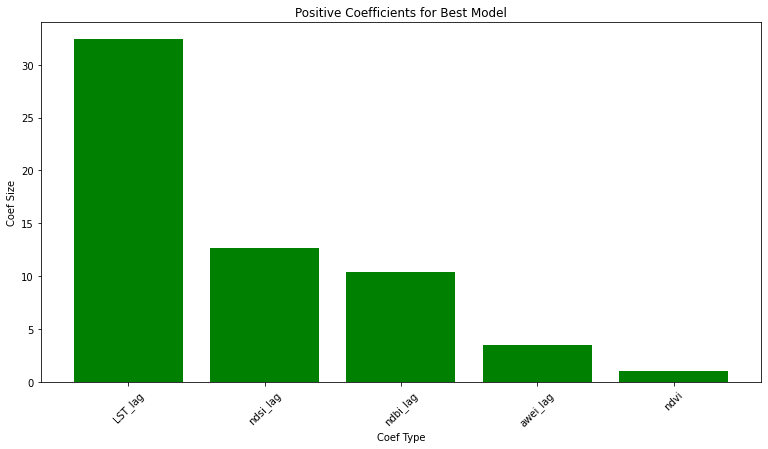

In [233]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

top_pos_coefs = coefs.head(5)
labels = top_pos_coefs.index.values
display(top_pos_coefs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,top_pos_coefs['coef'], color='green')
plt.xticks(rotation=45)
plt.xlabel("Coef Type")
plt.ylabel("Coef Size")
plt.title("Positive Coefficients for Best Model")
plt.show()

,coef
albedo_lag,1.67
awei,2.08
ndvi_lag,2.19
ndbi,13.37
ndsi,15.73


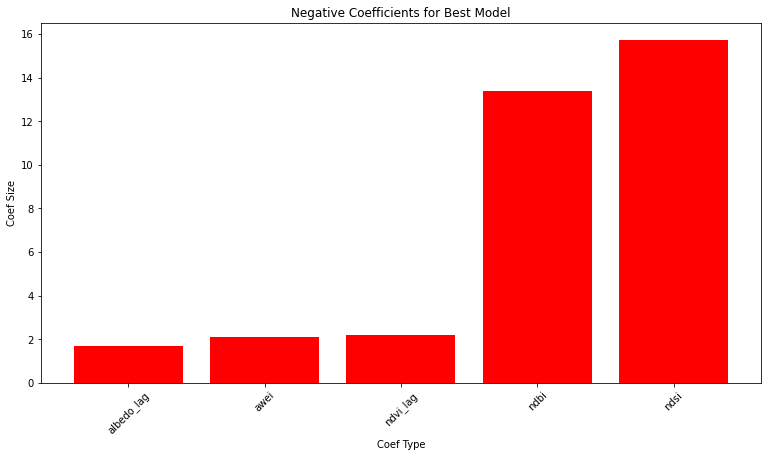

In [235]:
top_neg_coefs = coefs.tail(5).abs()
labels = top_neg_coefs.index.values
display(top_neg_coefs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,top_neg_coefs['coef'], color='red')
plt.xticks(rotation=45)
plt.xlabel("Coef Type")
plt.ylabel("Coef Size")
plt.title("Negative Coefficients for Best Model")
plt.show()